## Interpolation with grid refinement

yt_xarray : [INFO ] 2024-03-12 14:47:51,776:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 14:47:52,143:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 14:47:52,153:  Decomposed into 129 grids after 26 iterations.
yt : [INFO     ] 2024-03-12 14:47:52,215 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 14:47:52,216 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-03-12 14:47:52,216 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 14:47:52,217 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 14:47:52,217 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 14:47:52,493 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 14:47:52,494 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 14:47:52,496 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 14:47:52,49


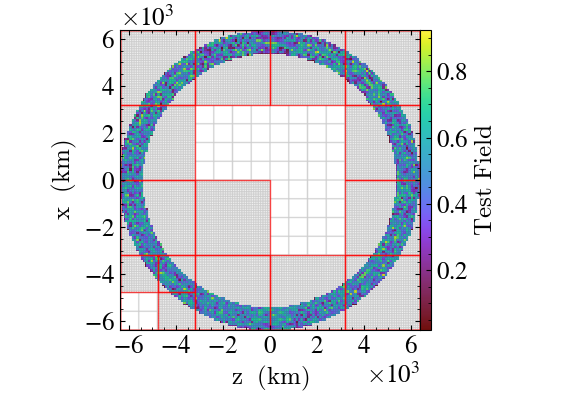

yt_xarray : [INFO ] 2024-03-12 14:47:53,376:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 14:47:53,558:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 14:47:53,576:  Decomposed into 247 grids after 51 iterations.
yt : [INFO     ] 2024-03-12 14:47:53,622 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 14:47:53,623 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-03-12 14:47:53,623 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 14:47:53,624 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 14:47:53,624 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 14:47:53,862 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 14:47:53,863 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 14:47:53,865 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 14:47:53,86


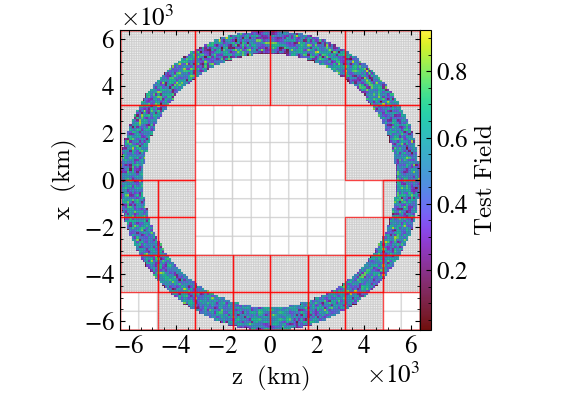

yt_xarray : [INFO ] 2024-03-12 14:47:54,419:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 14:47:54,593:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 14:47:54,617:  Decomposed into 339 grids after 101 iterations.
yt : [INFO     ] 2024-03-12 14:47:54,665 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 14:47:54,665 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-03-12 14:47:54,666 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 14:47:54,666 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 14:47:54,667 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 14:47:54,950 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 14:47:54,951 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 14:47:54,953 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 14:47:54,9


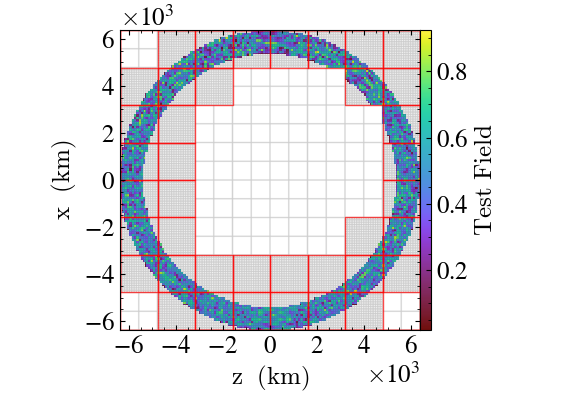

yt_xarray : [INFO ] 2024-03-12 14:47:55,427:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 14:47:55,602:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 14:47:55,630:  Decomposed into 339 grids after 401 iterations.
yt : [INFO     ] 2024-03-12 14:47:55,671 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 14:47:55,672 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-03-12 14:47:55,672 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 14:47:55,673 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 14:47:55,673 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 14:47:55,957 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 14:47:55,957 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 14:47:55,959 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 14:47:55,9


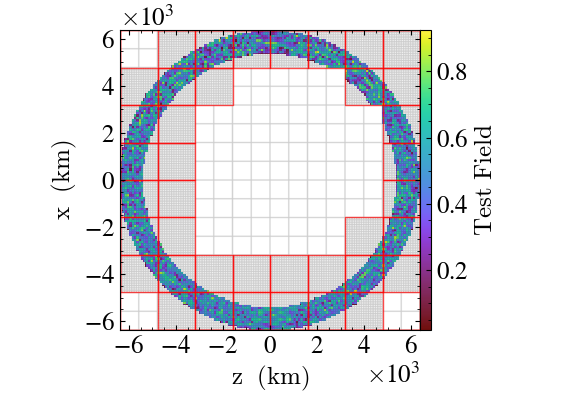

yt_xarray : [INFO ] 2024-03-12 14:47:56,525:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 14:47:56,702:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 14:47:56,731:  Decomposed into 339 grids after 408 iterations.
yt : [INFO     ] 2024-03-12 14:47:56,772 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 14:47:56,773 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-03-12 14:47:56,774 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 14:47:56,774 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 14:47:56,775 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 14:47:57,061 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 14:47:57,061 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 14:47:57,063 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 14:47:57,0


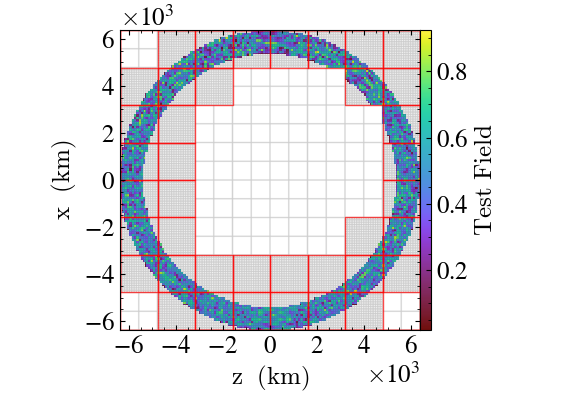

In [1]:
from yt_xarray.utilities._utilities import (
    construct_minimal_ds,
)
from yt_xarray.transformations import build_interpolated_cartesian_ds
import yt 

dim_names = ("longitude", "latitude", "depth")


ds = construct_minimal_ds(    
    min_x=0, 
    max_x=360,
    x_stretched=False,
    x_name=dim_names[0],
    n_x=50,
    min_y=-90., 
    max_y=90,
    y_stretched=False,
    y_name=dim_names[1],
    n_y=60,    
    z_stretched=False,
    z_name=dim_names[2],
    n_z=80,
    min_z=0.0,
    max_z=1000.0, 
)

fields = list(ds.data_vars)

for max_iters in (25, 50, 100, 400, 800):    
    ds_yt = build_interpolated_cartesian_ds(
        ds, 
        ('test_field',),
        'depth', 
        grid_resolution = (16,16,16),      
        refine_grid=True,
        refine_max_iters=max_iters,
        refine_min_grid_size=4, 
        refine_by=8,
    )
    
    slc = yt.SlicePlot(ds_yt, 'y', ('test_field'), window_size=(3,3))
    slc.set_log('test_field', False)
    slc.annotate_cell_edges(alpha=0.2)    
    slc.annotate_grids(edgecolors=(1.,0,0,0))
    slc.show()

yt_xarray : [INFO ] 2024-03-12 14:50:33,005:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 14:50:33,190:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 14:50:33,212:  Decomposed into 248 grids after 301 iterations.
yt : [INFO     ] 2024-03-12 14:50:33,251 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 14:50:33,252 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-03-12 14:50:33,252 Parameters: domain_left_edge          = [-3271. -5573.  2533.]
yt : [INFO     ] 2024-03-12 14:50:33,253 Parameters: domain_right_edge         = [ -334. -2832.  4870.]
yt : [INFO     ] 2024-03-12 14:50:33,253 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 14:50:33,542 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 14:50:33,542 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 14:50:33,544 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 14:50:


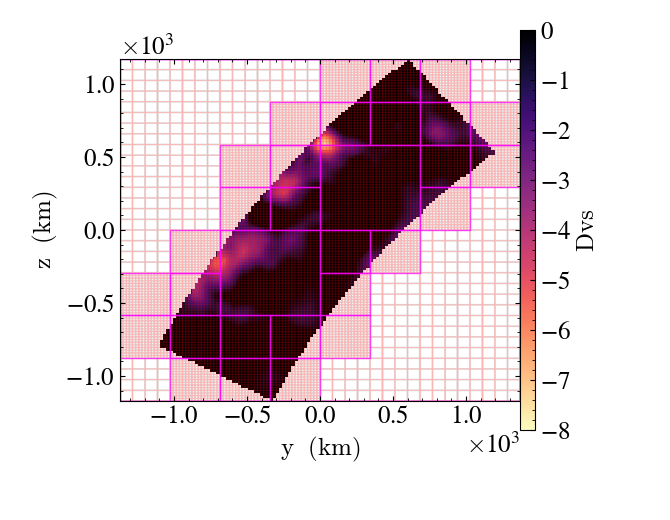

In [8]:
import xarray as xr
import yt_xarray
import yt
from yt_xarray import transformations

ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")
grid_resolution = (32, 32, 32)
ds_yt = transformations.build_interpolated_cartesian_ds(
    ds,
    [
        "dvs",
    ],
    "depth",
    grid_resolution = grid_resolution, 
    refine_grid=True,    
    refine_max_iters=2000,
    refine_min_grid_size=8,
    refine_by=4,
)


slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'dvs'), window_size=(4,4))
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -8, 0)
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,1,1))
slc.show()

yt : [INFO     ] 2024-03-12 14:50:34,337 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 14:50:34,338 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 14:50:34,340 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 14:50:34,340 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 14:50:34,341 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



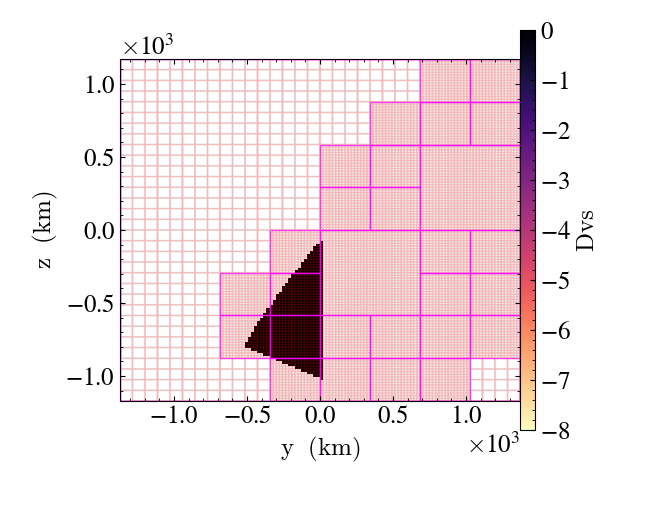

yt : [INFO     ] 2024-03-12 14:50:35,231 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 14:50:35,232 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 14:50:35,234 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 14:50:35,234 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 14:50:35,235 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



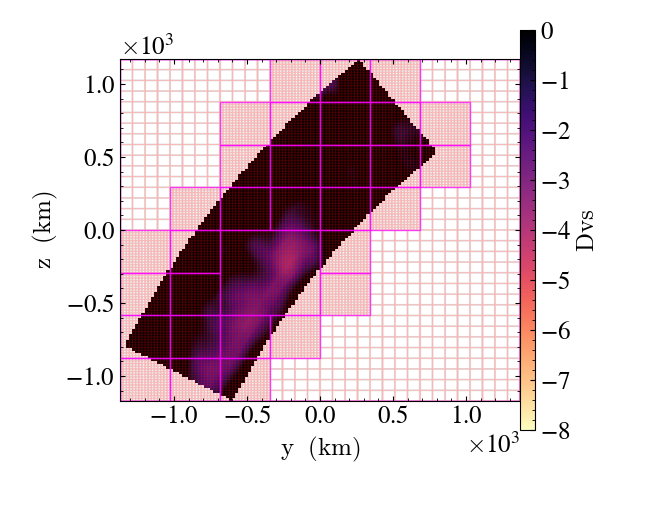

In [9]:
c = ds_yt.domain_center.copy()
c[0] = -3000.
slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'dvs'), window_size=(4,4), center=c)
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -8, 0)
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,1,1))
slc.show()

c[0] = -800.
slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'dvs'), window_size=(4,4), center=c)
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -8, 0)
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,1,1))
slc.show()

yt : [WARNING  ] 2024-03-12 14:50:36,013 Field ('stream', 'slow_dvs') was added without specifying units or dimensions, auto setting units to 'dimensionless'
yt : [INFO     ] 2024-03-12 14:50:36,013 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 14:50:36,014 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 14:50:36,016 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 14:50:36,016 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 14:50:36,018 Making a fixed resolution buffer of (('stream', 'slow_dvs')) 800 by 800



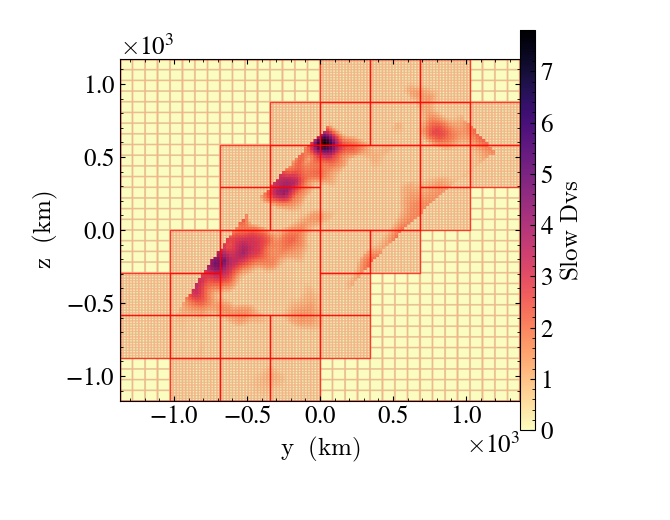

yt : [INFO     ] 2024-03-12 14:50:36,866 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 14:50:36,866 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 14:50:36,868 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 14:50:36,869 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 14:50:36,870 Making a fixed resolution buffer of (('stream', 'slow_dvs')) 800 by 800



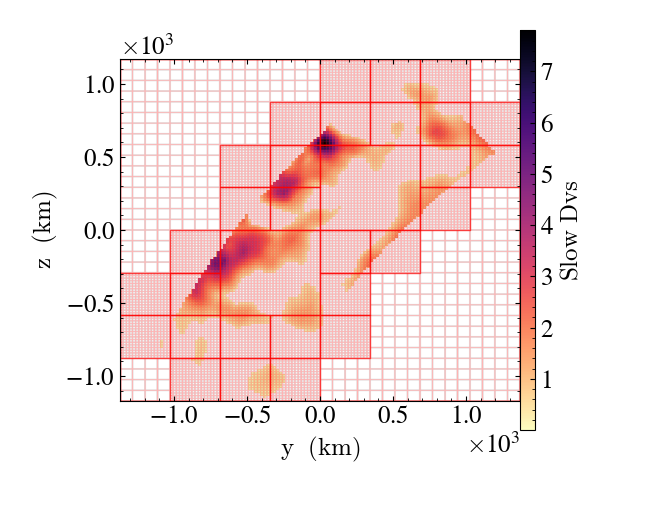

In [10]:
import numpy as np 

fill_val_dict = {'val': 0.0}
def _slow_vels(field, data):
    # return negative velocities only, 0 all other elements
    dvs = data['dvs'].copy()
    dvs[np.isnan(dvs)] = fill_val_dict['val']
    dvs[dvs>0] = fill_val_dict['val']
    return np.abs(dvs)

ds_yt.add_field(
    name=("stream", "slow_dvs"),
    function=_slow_vels,
    sampling_type="local",
)

slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'slow_dvs'), window_size=(4,4))
slc.set_log(("stream", "slow_dvs"), False)
slc.set_cmap(("stream", "slow_dvs"), "magma_r")
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,0,1))
slc.show()

fill_val_dict['val'] = np.nan
slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'slow_dvs'), window_size=(4,4))
slc.set_log(("stream", "slow_dvs"), False)
slc.set_cmap(("stream", "slow_dvs"), "magma_r")
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,0,1))
slc.show()

yt : [INFO     ] 2024-03-12 14:51:21,888 Rendering scene (Can take a while).
yt : [INFO     ] 2024-03-12 14:51:21,890 Creating volume
yt : [INFO     ] 2024-03-12 14:51:23,848 Creating transfer function


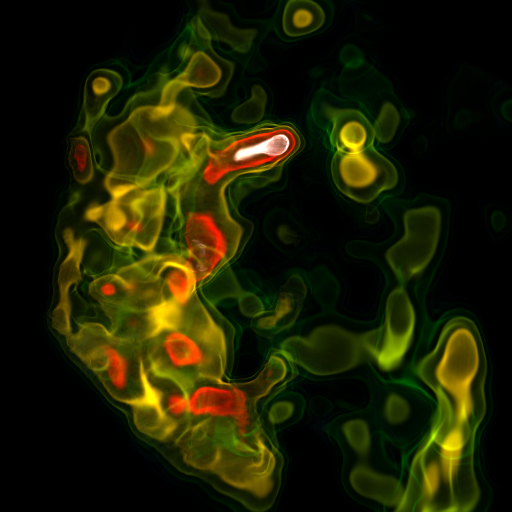

In [11]:
fill_val_dict['val'] = 0.0
reg = ds_yt.region( ds_yt.domain_center, ds_yt.domain_left_edge, ds_yt.domain_right_edge)
reg

sc = yt.create_scene(reg, field=('stream', 'slow_dvs'))

cam = sc.add_camera(ds_yt)

source = sc[0]

# Set the bounds of the transfer function
source.tfh.set_bounds((0.1, 8))

# set that the transfer function should be evaluated in log space
source.tfh.set_log(True)

# source.tfh.plot("transfer_function.png", profile_field=('stream', 'slow_dvs'))
cam.zoom(2)
cam.yaw(100*np.pi/180)
cam.roll(220*np.pi/180)
cam.rotate(30*np.pi/180)

sc.show(sigma_clip=5.)

